# 4 or more ML Classifiers - Submission

Will basically copy over first_model notebook things, and then make new models sections. Thinking of doing Logistic Regression, XGBoost, and SVM. Open to other models.

<h3>Setup and Imports</h3>

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully!")
print(f"✓ Random seed set to: 42")

✓ Libraries imported successfully!
✓ Random seed set to: 42


<h1>Load Preprocessed Data</h1>
<b>Load data and perform embedded vector conversion from string to numerical</b>

In [2]:
# Load the preprocessed dataset with NLP embeddings
df = pd.read_csv('data/processed/games_preprocessed.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total samples: {df.shape[0]:,}")
print(f"Total features (including target): {df.shape[1]}")
print("\nFirst few rows:")
display(df.head())

# Check for any missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset shape: (89302, 109)
Total samples: 89,302
Total features (including target): 109

First few rows:


,Price,DLC count,About the game,Windows,Mac,Linux,Achievements,Release_Year,Release_Month,Release_Day,...,Publishers_LTD,Publishers_EroticGamesClub,Publishers_Square_Enix,Publishers_Strategy_First,Publishers_HH_Games,Publishers_Choice_of_Games,Publishers_Sekai_Project,Publishers_Electronic_Arts,Publishers_Atomic_Fabrik,popularity_class
0,2.007898,-0.039159,[ 2.43655536e-02 -4.33482192e-02 -1.89679326e-...,True,False,False,0.057969,2008,10,21,...,0,0,0,0,0,0,0,0,0,Low
1,-0.963858,-0.039159,[-1.18375435e-01 6.85120896e-02 -8.45908746e-...,True,True,False,-0.049630,2017,10,12,...,0,0,0,0,0,0,0,0,0,Low
2,-0.338225,-0.039159,[-7.47546032e-02 -1.29440166e-02 2.83202082e-...,True,False,False,-0.121362,2021,11,17,...,0,0,0,0,0,0,0,0,0,Low
3,-0.181817,-0.039159,[ 2.98691001e-02 1.47273587e-02 5.98186301e-...,True,True,True,-0.121362,2020,7,23,...,0,0,0,0,0,0,0,0,0,Low
4,-1.118702,-0.039159,[-6.26481697e-02 7.47049646e-03 -5.16111143e-...,True,True,False,-0.019741,2020,2,3,...,0,0,0,0,0,0,0,0,0,Low



Missing values: 0


<b>Conversion from string embedded vectors to numeric embedded vectors</b>

In [3]:
import ast

# Check if 'About the game' column exists and contains string representations of arrays
if 'About the game' in df.columns:
    print("Converting 'About the game' embeddings from strings to numeric arrays...")
    
    # Convert string representations to actual arrays
    def string_to_array(s):
        if isinstance(s, str):
            # Remove extra whitespace and convert to numpy array
            return np.fromstring(s.strip('[]'), sep=' ')
        return s
    
    df['About the game'] = df['About the game'].apply(string_to_array)
    
    print(f"✓ Conversion complete!")
    print(f"✓ Sample embedding shape: {df['About the game'].iloc[0].shape}")
    print(f"✓ Sample embedding (first 10 values): {df['About the game'].iloc[0][:10]}")
else:
    print("'About the game' column not found in dataset")

Converting 'About the game' embeddings from strings to numeric arrays...
✓ Conversion complete!
✓ Sample embedding shape: (384,)
✓ Sample embedding (first 10 values): [ 0.02436555 -0.04334822 -0.00189679 -0.03764986 -0.08963642  0.02961544
 -0.0579943   0.0187653   0.01877719  0.06303879]


<b>Place numeric embedded vectors back into the 'About the game' column</b>

In [4]:
# Expand embeddings into separate columns
# This is necessary because sklearn models need 2D numeric arrays, not arrays within cells

if 'About the game' in df.columns:
    print("Expanding embeddings into separate columns...")
    
    # Convert the 'About the game' column (which contains arrays) into separate columns
    embeddings_list = df['About the game'].tolist()
    embeddings_df = pd.DataFrame(embeddings_list, 
                                  columns=[f'embedding_{i}' for i in range(len(embeddings_list[0]))])
    
    # Drop the original 'About the game' column
    df = df.drop('About the game', axis=1)
    
    # Insert embedding columns at the beginning
    df = pd.concat([embeddings_df, df], axis=1)
    
    print(f"✓ Expanded embeddings into {len(embeddings_list[0])} numeric columns")
    print(f"✓ New dataset shape: {df.shape}")
    print(f"✓ First few column names: {df.columns[:5].tolist()}")
    print(f"✓ Last few column names: {df.columns[-5:].tolist()}")
else:
    print("No embedding expansion needed - 'About the game' not found")

Expanding embeddings into separate columns...
✓ Expanded embeddings into 384 numeric columns
✓ New dataset shape: (89302, 492)
✓ First few column names: ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4']
✓ Last few column names: ['Publishers_Choice_of_Games', 'Publishers_Sekai_Project', 'Publishers_Electronic_Arts', 'Publishers_Atomic_Fabrik', 'popularity_class']


In [5]:
# Check target variable distribution
print("Target variable distribution:")
print(df['popularity_class'].value_counts())
print("\nPercentage distribution:")
print(df['popularity_class'].value_counts(normalize=True) * 100)

Target variable distribution:
popularity_class
Low       78429
Medium     8934
High       1939
Name: count, dtype: int64

Percentage distribution:
popularity_class
Low       87.824461
Medium    10.004255
High       2.171284
Name: proportion, dtype: float64


<h1>Prepared Raw and Processed Data for Models</h1>

In [6]:
# Separate features and target
X = df.drop('popularity_class', axis=1)
y = df['popularity_class']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nTotal number of features: {X.shape[1]}")
print(f"\nFeature data types:")
print(X.dtypes.value_counts())

Features (X) shape: (89302, 491)
Target (y) shape: (89302,)

Total number of features: 491

Feature data types:
float64    387
int64      101
bool         3
Name: count, dtype: int64


<b>Encode Target Variable for XGBoost Compatibility</b>

XGBoost requires the target variable to be numeric. This section converts string labels ('High', 'Low', 'Medium') to numeric values (0, 1, 2) using LabelEncoder. All models will use these encoded labels for consistency and efficiency. 

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable (convert 'High', 'Low', 'Medium' to numeric)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(f"Target variable encoded to numeric values")
print(f"Class mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
print(f"Target shape: {y.shape}")

Target variable encoded to numeric values
Class mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}
Target shape: (89302,)


<b>Ensure all data is in some numeric form</b>

In [8]:
# Check for non-numeric columns in X
print("Checking for non-numeric columns...")
print(f"\nData types in features:")
print(X.dtypes.value_counts())

# Identify object (string) columns
object_cols = X.select_dtypes(include=['object']).columns.tolist()

if object_cols:
    print(f"\n⚠ Found {len(object_cols)} non-numeric columns:")
    for col in object_cols:
        print(f"  - {col}: {X[col].nunique()} unique values")
        print(f"    Sample values: {X[col].dropna().head(3).tolist()}")
    
    print(f"\n🔧 Dropping non-numeric columns: {object_cols}")
    X = X.drop(columns=object_cols)
    print(f"✓ Remaining features: {X.shape[1]}")
else:
    print("✓ All columns are numeric!")

print(f"\nFinal feature set shape: {X.shape}")
print(f"Final feature types:\n{X.dtypes.value_counts()}")

Checking for non-numeric columns...

Data types in features:
float64    387
int64      101
bool         3
Name: count, dtype: int64
✓ All columns are numeric!

Final feature set shape: (89302, 491)
Final feature types:
float64    387
int64      101
bool         3
Name: count, dtype: int64


<b>Split data into training and test sets</b>

In [9]:
# Split data into training and testing sets (80/20 split)
# Use stratify to maintain class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 71441 samples
Testing set size: 17861 samples


<h1>Re-perform Split Again after using SelectKBest to Find 20 Best Features</h1>
<b>Perform SelectKBest on the data with ANOVA F-statistic</b>

In [10]:
print("Features before SelectKBest with ANOVA: ", X.shape)
X_new = SelectKBest(f_classif, k=20).fit_transform(X, y)

print("Features after SelectKBest with ANOVA:  ", X_new.shape)

Features before SelectKBest with ANOVA:  (89302, 491)
Features after SelectKBest with ANOVA:   (89302, 20)


<b>Recreate test split in X_newTrain, X_NewTest, Y_NewTrain, Y_NewTest</b>

In [11]:
# Split data into training and testing sets (80/20 split)
# Use stratify to maintain class distribution in both sets
X_NewTrain, X_NewTest, y_NewTrain, y_NewTest = train_test_split(
    X_new, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 71441 samples
Testing set size: 17861 samples


<h1>Model 1-1: Random Forest with Full Feature Set</h1>
  
<b>Define and Fit the Model for Learning</b>

In [12]:
# Initialize the Random Forest Classifier for Model 1 (Full Feature Set)
model_M1 = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

print("Training Model 1 with full feature set...")
# Fit the model on training set
model_M1.fit(X_train, y_train)
print("✓ Model 1 training complete!")

Training Model 1 with full feature set...
✓ Model 1 training complete!


<b>Save Fitted Model to Disk and Evaluate Model's Performance with accuracy and F1-Score</b>

In [13]:
# Save Model 1 to disk
import sklearn
filename_M1 = 'finalized_model_M1-1.sav'
pickle.dump(model_M1, open(filename_M1, 'wb'))
print(f"✓ Model 1 saved as: {filename_M1}")

# Load the model from disk to verify
loaded_model_M1 = pickle.load(open(filename_M1, 'rb'))
result_M1 = loaded_model_M1.score(X_test, y_test)
print(f"✓ Model 1 loaded and verified")
print(f"✓ Test score: {result_M1}")

# Use f1 score as well since accuracy may be insufficient for imbalanced classes
# f1 = 2 * [(precision*recall)/(precision+recall)]
# this way we can account for precision and recall as well as accuracy
y_pred = loaded_model_M1.predict(X_test)
modelF1Score = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
print(f"✓ F1score: {modelF1Score}")

✓ Model 1 saved as: finalized_model_M1-1.sav
✓ Model 1 loaded and verified
✓ Test score: 0.8795140249706064
✓ F1score: 0.8255864353178206


<h1>Model 1-2: Random Forest with Reduced (SelectKBest 20) Features</h1>
  
<b>Load and Fit Model with New Reduced Feature Set</b>

In [14]:
# Initialize the Random Forest Classifier for Model 2 (Best Features)
model_M2 = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

print("Training Model 2 with full feature set...")
# Fit the model on training set
ovrM2 = OneVsRestClassifier(model_M2)
ovrM2.fit(X_NewTrain, y_NewTrain)
print("✓ Model 2 training complete!")

Training Model 2 with full feature set...
✓ Model 2 training complete!


<b>Save Fitted Model to Disk and Evaluate Model's Performance with accuracy and F1-Score</b>

In [15]:
# Save Model 2 to disk
import sklearn
filename_M2 = 'finalized_model_M1-2.sav'
pickle.dump(ovrM2, open(filename_M2, 'wb'))
print(f"✓ Model 2 saved as: {filename_M2}")

# Load the model from disk to verify
loaded_model_M2 = pickle.load(open(filename_M2, 'rb'))
result_M2 = loaded_model_M2.score(X_NewTest, y_NewTest)
print(f"✓ Model 2 loaded and verified")
print(f"✓ Test score: {result_M2}")

# Use f1 score as well since accuracy may be insufficient for imbalanced classes
# f1 = 2 * [(precision*recall)/(precision+recall)]
# this way we can account for precision and recall as well as accuracy
y_NewPred = loaded_model_M2.predict(X_NewTest)
model2F1Score = sklearn.metrics.f1_score(y_NewTest, y_NewPred, average=None)
print(f"✓ F1score: {model2F1Score}")

✓ Model 2 saved as: finalized_model_M1-2.sav
✓ Model 2 loaded and verified
✓ Test score: 0.8333240020155647
✓ F1score: [0.35836627 0.91169404 0.39213974]


Confusion matrix, without normalization
[[  136    77   175]
 [  116 13850  1720]
 [  119   770   898]]
Normalized confusion matrix
[[0.35051546 0.19845361 0.45103093]
 [0.00739513 0.88295295 0.10965192]
 [0.06659205 0.43088976 0.50251819]]


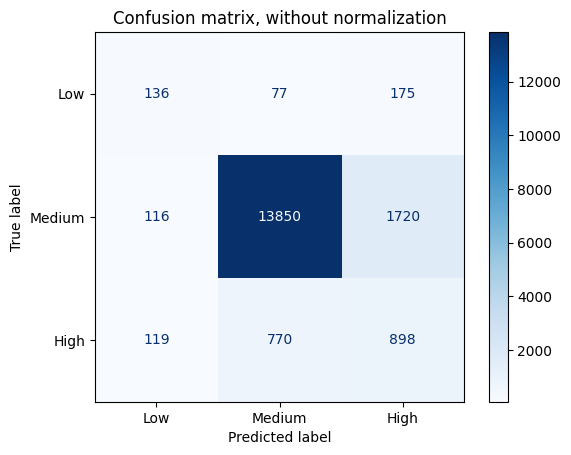

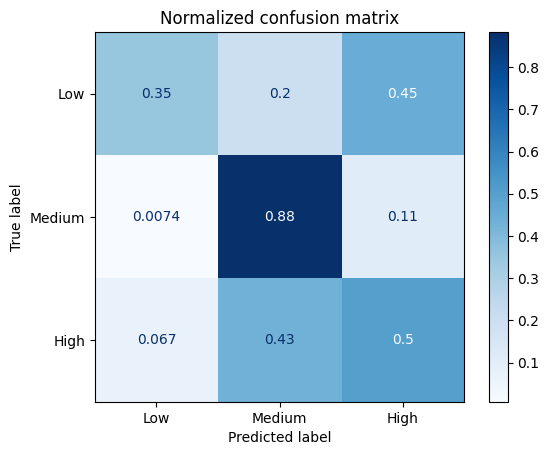

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        loaded_model_M2,
        X_NewTest,
        y_NewTest,
        display_labels="Low Medium High".split(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Model 2: Logistic Regression

## Model 2-1: Logistic Regression with Full Feature Set

Logistic Regression is a linear model that's simple, fast, and interpretable. It works well as a baseline model.

In [17]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression classifier
model_LR1 = LogisticRegression(
    max_iter=1000,  # Increase iterations for convergence with many features
    random_state=42,
    n_jobs=-1
)

print("Training Logistic Regression Model 2-1 with full feature set...")
# Fit the model on training set
model_LR1.fit(X_train, y_train)
print("✓ Logistic Regression Model 2-1 training complete!")

Training Logistic Regression Model 2-1 with full feature set...
✓ Logistic Regression Model 2-1 training complete!


**Save Model and Evaluate Performance**

In [18]:
# Save Logistic Regression Model 2-1 to disk
filename_LR1 = 'finalized_model_M2-1.sav'
pickle.dump(model_LR1, open(filename_LR1, 'wb'))
print(f"✓ Logistic Regression Model 2-1 saved as: {filename_LR1}")

# Load the model from disk to verify
loaded_model_LR1 = pickle.load(open(filename_LR1, 'rb'))
result_LR1 = loaded_model_LR1.score(X_test, y_test)
print(f"✓ Model 2-1 loaded and verified")
print(f"✓ Test score: {result_LR1}")

# Calculate F1 score
y_pred_LR1 = loaded_model_LR1.predict(X_test)
modelLR1_F1Score = f1_score(y_test, y_pred_LR1, average='weighted')
print(f"✓ F1score: {modelLR1_F1Score}")

✓ Logistic Regression Model 2-1 saved as: finalized_model_M2-1.sav
✓ Model 2-1 loaded and verified
✓ Test score: 0.8902077151335311
✓ F1score: 0.8676379194316232


## Model 2-2: Logistic Regression with Reduced Feature Set

Train Logistic Regression using the 20 best features selected by SelectKBest.

In [19]:
# Initialize Logistic Regression classifier for reduced features
model_LR2 = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

ovrLR2 = OneVsRestClassifier(model_LR2)

print("Training Logistic Regression Model 2-2 with reduced feature set (20 features)...")
# Fit the model on training set with selected features
# model_LR2.fit(X_NewTrain, y_NewTrain)
y_score = ovrLR2.fit(X_NewTrain, y_NewTrain).decision_function(X_NewTest)
print("✓ Logistic Regression Model 2-2 training complete!")

Training Logistic Regression Model 2-2 with reduced feature set (20 features)...
✓ Logistic Regression Model 2-2 training complete!


**Save Model and Evaluate Performance**

In [20]:
# Save the trained model to a file
filename = 'finalized_model_M2-2.sav'
pickle.dump(ovrLR2, open(filename, 'wb'))
print(f"✓ Model saved as {filename}")

# Load the model to verify it was saved correctly
loaded_model_LR2 = pickle.load(open(filename, 'rb'))
print("✓ Model loaded successfully")

# Make predictions on test set
# y_pred_LR2 = loaded_model_LR2.predict(X_NewTest)
y_pred_LR2 = loaded_model_LR2.predict(X_NewTest)

# Calculate accuracy and F1 score
accuracy_LR2 = accuracy_score(y_NewTest, y_pred_LR2)
f1_LR2 = f1_score(y_NewTest, y_pred_LR2, average='weighted')

print(f"\nLogistic Regression Model 2-2 Performance:")
print(f"  Accuracy: {accuracy_LR2:.4f} ({accuracy_LR2*100:.2f}%)")
print(f"  F1 Score (weighted): {f1_LR2:.4f} ({f1_LR2*100:.2f}%)")

✓ Model saved as finalized_model_M2-2.sav
✓ Model loaded successfully

Logistic Regression Model 2-2 Performance:
  Accuracy: 0.7791 (77.91%)
  F1 Score (weighted): 0.8147 (81.47%)


<b>Confusion Matrix on Reduced Feature Set</b>

Confusion matrix, without normalization
[[  228    46   114]
 [  778 12800  2108]
 [  337   563   887]]
Normalized confusion matrix
[[0.58762887 0.1185567  0.29381443]
 [0.04959837 0.81601428 0.13438735]
 [0.18858422 0.31505316 0.49636262]]


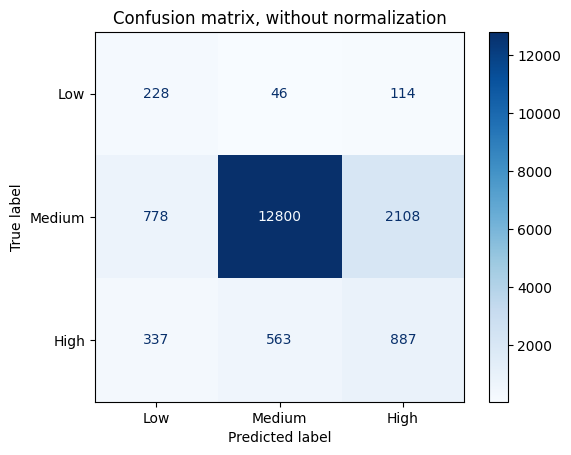

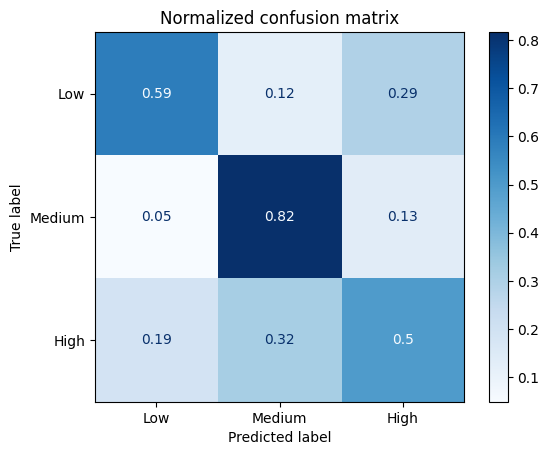

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        loaded_model_LR2,
        X_NewTest,
        y_NewTest,
        display_labels="Low Medium High".split(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [22]:
# from sklearn.metrics import roc_curve, auc

# testy = sklearn.preprocessing.label_binarize(y, classes=[0, 1, 2])
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(3):
#     fpr[i], tpr[i], _ = roc_curve(y_NewTest[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot of a ROC curve for a specific class
# for i in range(3):
#     plt.figure()
#     plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()

# Model 3: XGBoost (Gradient Boosting)

## Model 3-1: XGBoost with Full Feature Set

XGBoost is a powerful ensemble method that uses gradient boosting. It's known for high performance on structured data.

In [23]:
from xgboost import XGBClassifier

# Initialize XGBoost classifier
model_XGB1 = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'  # For multi-class classification
)

print("Training XGBoost Model 3-1 with full feature set...")
# Fit the model on training set
model_XGB1.fit(X_train, y_train)
print("✓ XGBoost Model 3-1 training complete!")

Training XGBoost Model 3-1 with full feature set...
✓ XGBoost Model 3-1 training complete!


**Save Model and Evaluate Performance**

In [24]:
# Save XGBoost Model 3-1 to disk
filename_XGB1 = 'finalized_model_M3-1.sav'
pickle.dump(model_XGB1, open(filename_XGB1, 'wb'))
print(f"✓ XGBoost Model 3-1 saved as: {filename_XGB1}")

# Load the model from disk to verify
loaded_model_XGB1 = pickle.load(open(filename_XGB1, 'rb'))
result_XGB1 = loaded_model_XGB1.score(X_test, y_test)
print(f"✓ Model 3-1 loaded and verified")
print(f"✓ Test score: {result_XGB1}")

# Calculate F1 score
y_pred_XGB1 = loaded_model_XGB1.predict(X_test)
modelXGB1_F1Score = f1_score(y_test, y_pred_XGB1, average='weighted')
print(f"✓ F1score: {modelXGB1_F1Score}")

✓ XGBoost Model 3-1 saved as: finalized_model_M3-1.sav
✓ Model 3-1 loaded and verified
✓ Test score: 0.9054924136386541
✓ F1score: 0.8915198984451778


## Model 3-2: XGBoost with Reduced Feature Set

Train XGBoost using the 20 best features selected by SelectKBest.

In [25]:
# Initialize XGBoost classifier for reduced features
model_XGB2 = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    class_weight='balanced'
)

print("Training XGBoost Model 3-2 with reduced feature set (20 features)...")
# Fit the model on training set with selected features
ovrXGB2 = OneVsRestClassifier(model_XGB2)
ovrXGB2.fit(X_NewTrain, y_NewTrain)
print("✓ XGBoost Model 3-2 training complete!")

Training XGBoost Model 3-2 with reduced feature set (20 features)...
✓ XGBoost Model 3-2 training complete!


**Save Model and Evaluate Performance**

In [26]:
# Save the trained model to a file
filename_XGB2 = 'finalized_model_M3-2.sav'
pickle.dump(ovrXGB2, open(filename_XGB2, 'wb'))
print(f"✓ Model saved as {filename_XGB2}")

# Load the model to verify it was saved correctly
loaded_model_XGB2 = pickle.load(open(filename_XGB2, 'rb'))
print("✓ Model loaded successfully")

# Make predictions on test set
y_pred_XGB2 = loaded_model_XGB2.predict(X_NewTest)

# Calculate accuracy and F1 score
accuracy_XGB2 = accuracy_score(y_NewTest, y_pred_XGB2)
f1_XGB2 = f1_score(y_NewTest, y_pred_XGB2, average='weighted')

print(f"\nXGBoost Model 3-2 Performance:")
print(f"  Accuracy: {accuracy_XGB2:.4f} ({accuracy_XGB2*100:.2f}%)")
print(f"  F1 Score (weighted): {f1_XGB2:.4f} ({f1_XGB2*100:.2f}%)")

✓ Model saved as finalized_model_M3-2.sav
✓ Model loaded successfully

XGBoost Model 3-2 Performance:
  Accuracy: 0.8996 (89.96%)
  F1 Score (weighted): 0.8827 (88.27%)


<b>Confusion Matrix with Reduced Feature Set</b>

Confusion matrix, without normalization
[[  137   109   142]
 [   16 15429   241]
 [   62  1223   502]]
Normalized confusion matrix
[[0.35309278 0.28092784 0.36597938]
 [0.00102002 0.98361596 0.01536402]
 [0.03469502 0.68438724 0.28091774]]


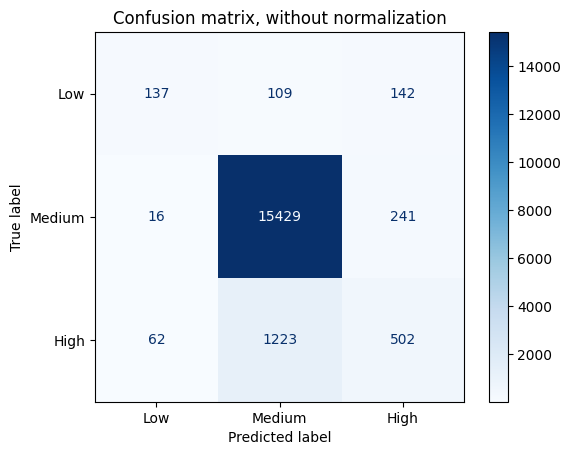

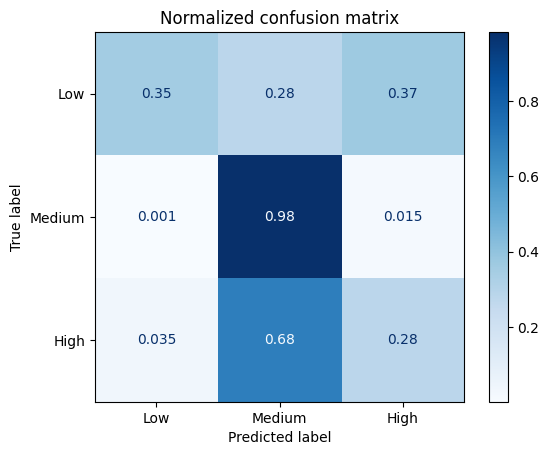

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        loaded_model_XGB2,
        X_NewTest,
        y_NewTest,
        display_labels="Low Medium High".split(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Model 4: Support Vector Machine (SVM)

## Model 4-1: SVM with Full Feature Set

SVM is effective for high-dimensional spaces. Using RBF kernel for non-linear classification.

**Note:** SVM can be slow with large datasets and many features, so this may take some time to train.

In [28]:
from sklearn.svm import SVC

# Initialize SVM classifier
model_SVM1 = SVC(
    kernel='rbf',  # Radial basis function kernel
    C=1.0,
    gamma='scale',
    random_state=42
)

print("Training SVM Model 4-1 with full feature set...")
print("⚠ This may take several minutes due to the large feature set...")
# Fit the model on training set
model_SVM1.fit(X_train, y_train)
print("✓ SVM Model 4-1 training complete!")

Training SVM Model 4-1 with full feature set...
⚠ This may take several minutes due to the large feature set...
✓ SVM Model 4-1 training complete!


**Save Model and Evaluate Performance**

In [29]:
# Save SVM Model 4-1 to disk
filename_SVM1 = 'finalized_model_M4-1.sav'
pickle.dump(model_SVM1, open(filename_SVM1, 'wb'))
print(f"✓ SVM Model 4-1 saved as: {filename_SVM1}")

# Load the model from disk to verify
loaded_model_SVM1 = pickle.load(open(filename_SVM1, 'rb'))
result_SVM1 = loaded_model_SVM1.score(X_test, y_test)
print(f"✓ Model 4-1 loaded and verified")
print(f"✓ Test score: {result_SVM1}")

# Calculate F1 score
y_pred_SVM1 = loaded_model_SVM1.predict(X_test)
modelSVM1_F1Score = f1_score(y_test, y_pred_SVM1, average='weighted')
print(f"✓ F1score: {modelSVM1_F1Score}")

✓ SVM Model 4-1 saved as: finalized_model_M4-1.sav
✓ Model 4-1 loaded and verified
✓ Test score: 0.8782263031185265
✓ F1score: 0.8212870176598328


## Model 4-2: SVM with Reduced Feature Set

Train SVM using the 20 best features. This should train much faster than the full feature set.

In [30]:
# Initialize SVM classifier for reduced features
model_SVM2 = SVC(
    kernel='rbf',
    C=10.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced'
)

ovrSVC = sklearn.multiclass.OneVsRestClassifier(model_SVM2)

print("Training SVM Model 4-2 with reduced feature set (20 features)...")
# Fit the model on training set with selected features
ovrSVC.fit(X_NewTrain, y_NewTrain)
print("✓ SVM Model 4-2 training complete!")

Training SVM Model 4-2 with reduced feature set (20 features)...
✓ SVM Model 4-2 training complete!


**Save Model and Evaluate Performance**

In [31]:
# Save the trained model to a file
filename_SVM2 = 'finalized_model_M4-2.sav'
pickle.dump(ovrSVC, open(filename_SVM2, 'wb'))
print(f"✓ Model saved as {filename_SVM2}")

# Load the model to verify it was saved correctly
loaded_model_SVM2 = pickle.load(open(filename_SVM2, 'rb'))
print("✓ Model loaded successfully")

# Make predictions on test set
y_pred_SVM2 = loaded_model_SVM2.predict(X_NewTest)

# Calculate accuracy and F1 score
accuracy_SVM2 = accuracy_score(y_NewTest, y_pred_SVM2)
f1_SVM2 = f1_score(y_NewTest, y_pred_SVM2, average='weighted')

print(f"\nSVM Model 4-2 Performance:")
print(f"  Accuracy: {accuracy_SVM2:.4f} ({accuracy_SVM2*100:.2f}%)")
print(f"  F1 Score (weighted): {f1_SVM2:.4f} ({f1_SVM2*100:.2f}%)")

✓ Model saved as finalized_model_M4-2.sav
✓ Model loaded successfully

SVM Model 4-2 Performance:
  Accuracy: 0.7207 (72.07%)
  F1 Score (weighted): 0.7640 (76.40%)


<b>Confusion Matrix with Reduced Feature Set</b>

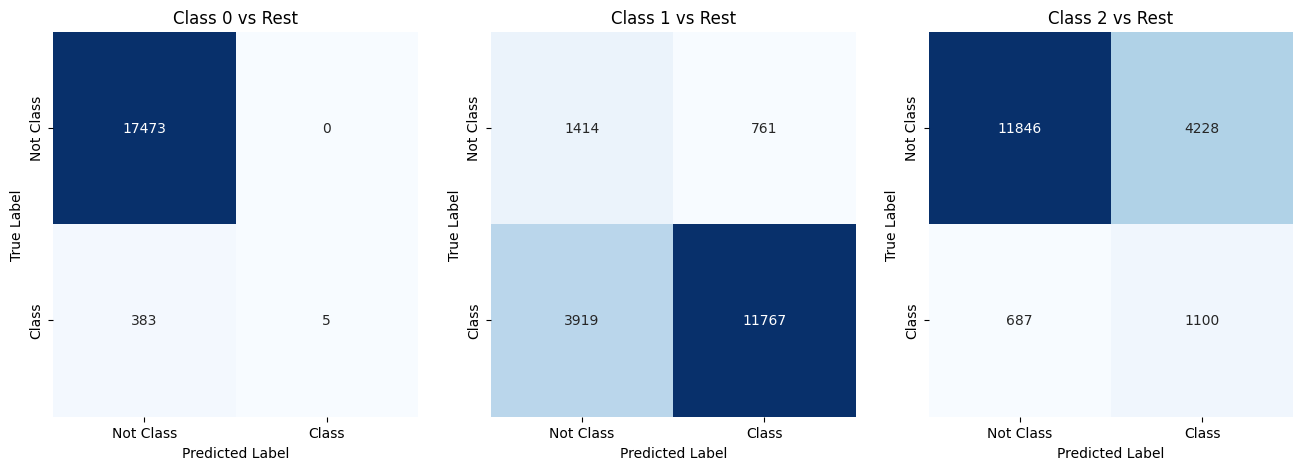

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
print("")
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
# classes = ovrSVC.classes_
classes = [0,1,2]
figure, axes = plt.subplots(1, 3, figsize=(16,5))
for i, ovrSVC in enumerate([0,1,2]):
    # for title, normalize in titles_options:
    y_NewTest_binary = (y_NewTest == classes[i]).astype(int)
    y_pred_SVM2_binary = (y_pred_SVM2 == classes[i]).astype(int)
    cm = sklearn.metrics.confusion_matrix(y_NewTest_binary, y_pred_SVM2_binary)
        # print(cm)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f"Class {classes[i]} vs Rest")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")
    axes[i].set_xticklabels(["Not Class", "Class"])
    axes[i].set_yticklabels(["Not Class", "Class"])
        # disp = ConfusionMatrixDisplay.from_estimator(
        # loaded_model_SVM2,
        # X_NewTest,
        # y_NewTest,
        # display_labels="Low Medium High".split(),
        # cmap=plt.cm.Blues,
        # normalize=normalize,
        # )
        # disp.ax_.set_title(title)        

        # print(title)
        # print(disp.confusion_matrix)
plt.show()

# Summary

This notebook implements **4 different ML classification techniques**, each with full and reduced feature sets:

1. **Random Forest** (Model 1-1, 1-2)
2. **Logistic Regression** (Model 2-1, 2-2)
3. **XGBoost** (Model 3-1, 3-2)
4. **Support Vector Machine** (Model 4-1, 4-2)

All models are saved as `.sav` files and evaluated using accuracy and weighted F1 score.